In [1]:
from qiskit_aer import AerSimulator
from qiskit import *
import supermarq
from qiskit.providers.fake_provider import *
import numpy as np 
import os

########## INPUT ############
f=5 # number of fake_backend want to choose
lower_limit= 3 # the lower limit of qubits for the circuit
upper_limit= 16 # the lower limit of qubits for the circuit
steps= 3 #jump in qubit numbers
name_of_algo='vanilla_qaoa'

In [2]:
#all_fakes=[FakeAlmadenV2,FakeArmonkV2,FakeAthensV2,FakeAuckland,FakeBelemV2,FakeBoeblingenV2,FakeBogotaV2,FakeBrooklynV2,FakeBurlingtonV2,FakeCairoV2,FakeCambridgeV2,FakeCasablancaV2,FakeEssexV2,FakeGeneva,FakeGuadalupeV2,FakeHanoiV2,FakeJakartaV2,FakeJohannesburgV2,FakeKolkataV2,FakeLagosV2,FakeLimaV2,FakeLondonV2,FakeManhattanV2,FakeManilaV2,FakeMelbourneV2,FakeMontrealV2,FakeMumbaiV2,FakeNairobiV2,FakeOslo,FakeOurenseV2,FakeParisV2,FakePerth,FakePrague,FakePoughkeepsieV2,FakeQuitoV2,FakeRochesterV2,FakeRomeV2,FakeSantiagoV2,FakeSherbrooke,FakeSingaporeV2,FakeSydneyV2,FakeTorontoV2,FakeValenciaV2,FakeVigoV2,FakeWashingtonV2,FakeYorktownV2]
#selected_fakes = random.sample(all_fakes, f)
#selected_fakes  # having any randomly selected 5 fake backends out of 46 mentioned in the inital list
selected_fakes=[FakeBoeblingenV2,FakeRomeV2,FakeGeneva,FakeTorontoV2,FakeRochesterV2]

In [3]:
benchmarks=[]
for i in range(lower_limit,upper_limit,steps):
    label = name_of_algo+str(i)
    benchmarks.append((supermarq.qaoa_vanilla_proxy.QAOAVanillaProxy(i),label))
for i in benchmarks:
    circuit=i[0].qiskit_circuit()
    print("--------------------------",i[1],"---------------------------")
    #circuit.draw(output="mpl")
    print(circuit.draw())       #uncomment it to print all the circuits

-------------------------- vanilla_qaoa3 ---------------------------
      ┌───┐                                                  ┌────────────┐»
 q_0: ┤ H ├──■───────────────────■────■───────────────────■──┤ Rx(8.8094) ├»
      ├───┤┌─┴─┐┌─────────────┐┌─┴─┐  │                   │  └────────────┘»
 q_1: ┤ H ├┤ X ├┤ Rz(-3.7571) ├┤ X ├──┼───────────────────┼────────■───────»
      ├───┤└───┘└─────────────┘└───┘┌─┴─┐┌─────────────┐┌─┴─┐    ┌─┴─┐     »
 q_2: ┤ H ├─────────────────────────┤ X ├┤ Rz(-3.7571) ├┤ X ├────┤ X ├─────»
      └───┘                         └───┘└─────────────┘└───┘    └───┘     »
m0: 3/═════════════════════════════════════════════════════════════════════»
                                                                           »
«                    ┌─┐                         
« q_0: ──────────────┤M├─────────────────────────
«                    └╥┘     ┌────────────┐┌─┐   
« q_1: ───────────────╫───■──┤ Rx(8.8094) ├┤M├───
«      ┌────────────┐ ║ ┌─┴─┐├────────

In [4]:
benchmark_features = {}
for benchmark, label in benchmarks:
    benchmark_features[label] = [
        supermarq.converters.compute_communication_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_depth_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_entanglement_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_liveness_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_measurement_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_parallelism_with_qiskit(benchmark.qiskit_circuit()),]
print(benchmark_features)

{'vanilla_qaoa3': [1.0, 1.0, 0.4, 0.6666666666666666, 0.0, 0.125], 'vanilla_qaoa6': [1.0, 0.6, 0.5263157894736842, 0.5166666666666667, 0.0, 0.18], 'vanilla_qaoa9': [1.0, 0.5, 0.5714285714285714, 0.40350877192982454, 0.0, 0.15131578947368424], 'vanilla_qaoa12': [1.0, 0.4393939393939394, 0.5945945945945946, 0.3388888888888889, 0.0, 0.13333333333333333], 'vanilla_qaoa15': [1.0, 0.3333333333333333, 0.6086956521739131, 0.35185185185185186, 0.0, 0.15674603174603177]}


In [5]:
import time
import pandas as pd
from IPython.display import display
jobs =[]
data=[]
print("=============SCORES OF ALL THE CIRCUITS=============")    
for backend in selected_fakes:
    print("BACKEND-NAME :: ", backend().name)
    for benchmark, label in benchmarks:
        circuit=benchmark.qiskit_circuit()
        score_list=[]
        timetaken=[]
        for i in range(0,1):
            start=time.time()
            job = backend().run(circuit, shots=1000)
            result = job.result()
            counts = job.result(0).get_counts()
            score = benchmark.score(counts)
            end=time.time()-start
            score_list.append(score)
            t=job.result(0).time_taken
            timetaken.append(t)
            print(i+1,"th iteration ,", label ," Execution time::",t, "Total Time Taken ::",end )
            #print(label ," ExecutionTime:",t,"& Total time:",end)
        #print("------------------------------------------")
        score = np.mean(score_list) 
        sd = np.std(score_list)
        execution_time = np.mean(timetaken)
        dictionary={}
        dictionary["Backend_Time"]=backend().name
        dictionary["Ciruit_Name"]=label    
        dictionary["Execution_Time"]=execution_time
        dictionary["Total_Time"]=end
        data.append(dictionary)
        jobs.append((label,benchmark,backend,job,score,sd,execution_time,end))
#jobs
df = pd.DataFrame(data)
display(df)
df.to_excel(r"./output_vanilla_qaoa.xlsx", index=False)

=============SCORES OF ALL THE CIRCUITS=============
BACKEND-NAME ::  fake_boeblingen
1 th iteration , vanilla_qaoa3  Execution time:: 0.5189354419708252 Total Time Taken :: 1.3212623596191406
1 th iteration , vanilla_qaoa6  Execution time:: 0.39502859115600586 Total Time Taken :: 1.334064245223999
1 th iteration , vanilla_qaoa9  Execution time:: 2.4324190616607666 Total Time Taken :: 3.3323962688446045
1 th iteration , vanilla_qaoa12  Execution time:: 1.1612095832824707 Total Time Taken :: 2.369345188140869
1 th iteration , vanilla_qaoa15  Execution time:: 5.017653703689575 Total Time Taken :: 6.978425979614258
BACKEND-NAME ::  fake_rome
1 th iteration , vanilla_qaoa3  Execution time:: 0.07240867614746094 Total Time Taken :: 0.2844407558441162
1 th iteration , vanilla_qaoa6  Execution time:: 0.3580331802368164 Total Time Taken :: 0.5283305644989014
1 th iteration , vanilla_qaoa9  Execution time:: 2.3376283645629883 Total Time Taken :: 2.5061326026916504
1 th iteration , vanilla_qaoa12

,Backend_Time,Ciruit_Name,Execution_Time,Total_Time
0,fake_boeblingen,vanilla_qaoa3,0.518935,1.321262
1,fake_boeblingen,vanilla_qaoa6,0.395029,1.334064
2,fake_boeblingen,vanilla_qaoa9,2.432419,3.332396
3,fake_boeblingen,vanilla_qaoa12,1.161210,2.369345
4,fake_boeblingen,vanilla_qaoa15,5.017654,6.978426
5,fake_rome,vanilla_qaoa3,0.072409,0.284441
6,fake_rome,vanilla_qaoa6,0.358033,0.528331
7,fake_rome,vanilla_qaoa9,2.337628,2.506133
8,fake_rome,vanilla_qaoa12,0.742639,1.039415
9,fake_rome,vanilla_qaoa15,4.199597,5.507713


In [6]:
all_scores={}  
all_fake_names=[]
all_fake_scores=[]
for i in selected_fakes:
    fakes=i
    #print("SELCETED_FAKES:: ",i)
    i={}
    for label,benchmark,backend,job,score,sd,exec,tot in jobs:
        #supermarq.plotting.plot_results([score], [label])
        if fakes == backend:
            i[label] = score
    device_scores = 'device_score_' +str(fakes().name)
    all_scores[device_scores]= i
    all_fake_scores.append(i)
    all_fake_names.append(device_scores)   
#print(all_scores)    

In [7]:
for label,benchmark,backend,job,score,sd,exec,tot in jobs:
    print("USED BACKEND::",backend().name,"; CIRCUIT_NAME:",label, "; SCORE =",score)
    #supermarq.plotting.plot_results([score], [label]) #uncomment it to print all the circuits
    print("-----------------------------------------------------------")

USED BACKEND:: fake_boeblingen ; CIRCUIT_NAME: vanilla_qaoa3 ; SCORE = 0.3139999960005193
-----------------------------------------------------------
USED BACKEND:: fake_boeblingen ; CIRCUIT_NAME: vanilla_qaoa6 ; SCORE = 0.6975315968926447
-----------------------------------------------------------
USED BACKEND:: fake_boeblingen ; CIRCUIT_NAME: vanilla_qaoa9 ; SCORE = 0.5297500082678278
-----------------------------------------------------------
USED BACKEND:: fake_boeblingen ; CIRCUIT_NAME: vanilla_qaoa12 ; SCORE = 0.560663648963619
-----------------------------------------------------------
USED BACKEND:: fake_boeblingen ; CIRCUIT_NAME: vanilla_qaoa15 ; SCORE = 0.5728422096094259
-----------------------------------------------------------
USED BACKEND:: fake_rome ; CIRCUIT_NAME: vanilla_qaoa3 ; SCORE = 0.391999997677721
-----------------------------------------------------------
USED BACKEND:: fake_rome ; CIRCUIT_NAME: vanilla_qaoa6 ; SCORE = 0.6932490690467337
----------------------

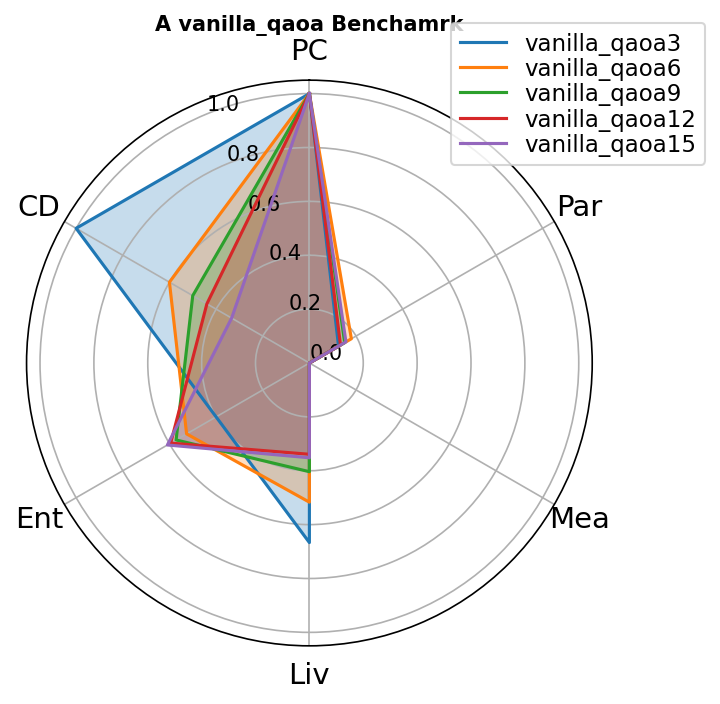

In [8]:
names=[]
scores=[]
X="A "+name_of_algo+' Benchamrk'
for i,j in benchmark_features.items():
    names.append(i)
    scores.append(j)
supermarq.plotting.plot_benchmark([X,names,scores],
        spoke_labels=["PC", "CD", "Ent", "Liv", "Mea", "Par"],show=True)

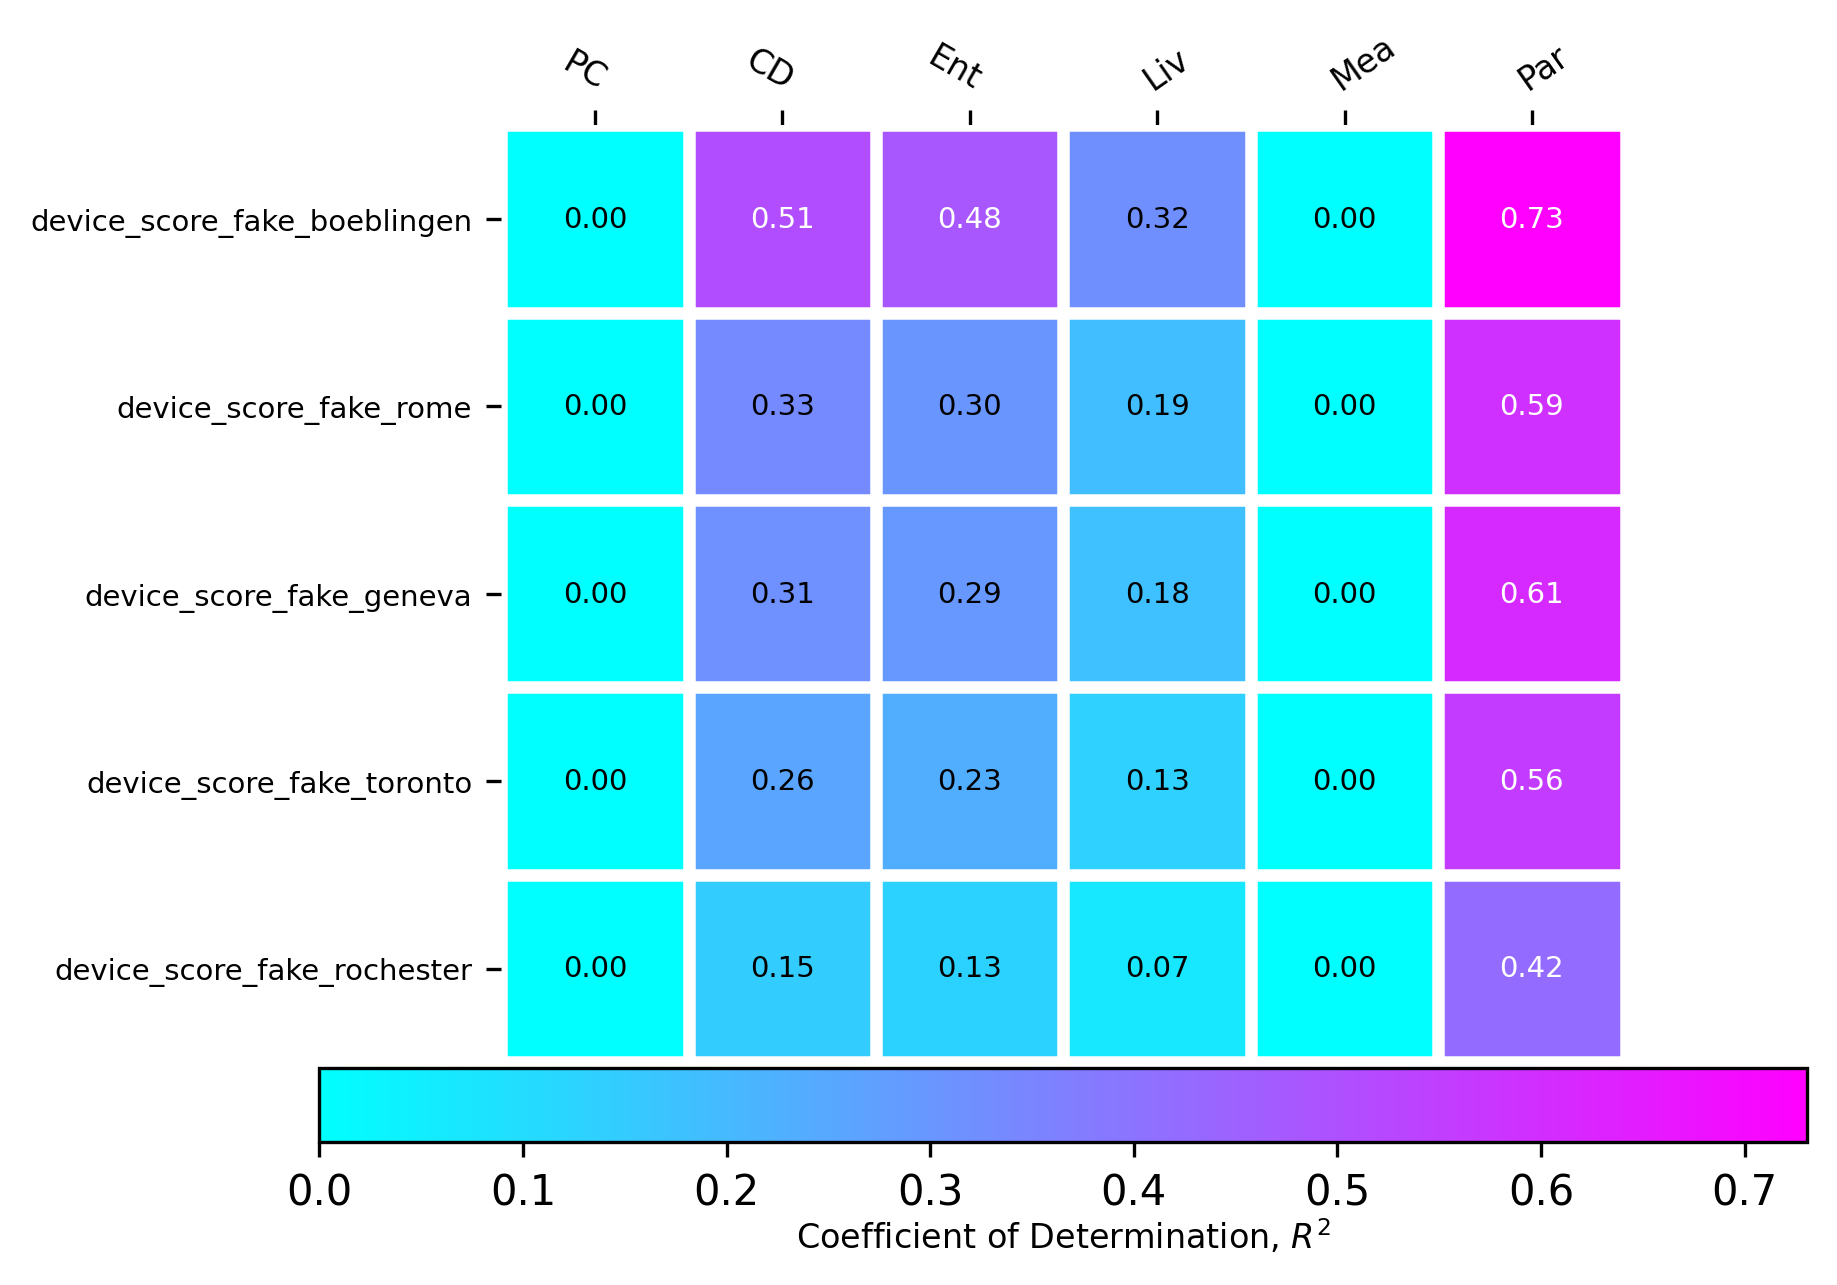

In [9]:
supermarq.plotting.plot_correlations(benchmark_features,all_fake_scores,["PC", "CD", "Ent", "Liv", "Mea", "Par"],device_name=all_fake_names,show=True,)

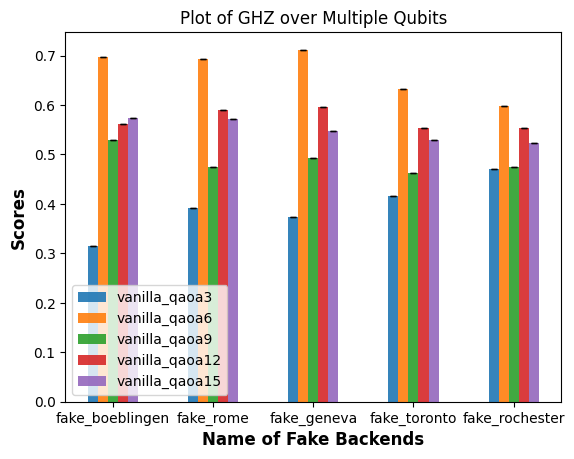

In [10]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import numpy as np
all_fake_names=[]
all_score=[]
all_sd=[]
all_ckt=[]
for i in selected_fakes:
    all_fake_names.append(i().name)    
for benchmark, label in benchmarks:
    i=[]
    j=[]
    k=[]
    for ckt,benchmark,backend,job,score,sd,exec,tot in jobs:
        if ckt == label:
            i.append(score)
            j.append(sd)
    all_ckt.append(label)
    all_score.append(i)
    all_sd.append(j)
num_bars = len(all_score)
width = 0.1
x = np.arange(len(all_fake_names)) # x-axis positions for each bar
fig, ax = plt.subplots()
for i in range(num_bars):               # Create bars for each category with appropriate offsets
    ax.bar(x + i * width, all_score[i], width=width, label=f'Bar {i+1}', 
           yerr=all_sd[i],align='center',alpha=0.9,ecolor='black',capsize=2)
ax.set_xlabel('Name of Fake Backends',fontweight ='bold',fontsize = 12)
ax.set_ylabel('Scores',fontweight ='bold',fontsize = 12)
ax.set_title('Plot of GHZ over Multiple Qubits')
ax.set_xticks(x + (num_bars - 1) * width / 2)
ax.set_xticklabels(all_fake_names)
ax.legend(all_ckt,loc="lower left")
#ax.grid(True)
plt.show()

In [11]:
import resource
def get_memory():
    usage = resource.getrusage(resource.RUSAGE_SELF)
    max_mem = usage.ru_maxrss/1024 #in MB
    return max_mem
get_memory()

755.109375